In [1]:
import sys   
sys.path.append('../../src/features')
import build_features as feature_builder

In [2]:
from datetime import date

start_date = date(2017, 1, 1)
end_date = date(2017, 12, 31)
airport_code = 'MDT'
path_to_db = "sqlite:///../../data/processed/airlines.db"


features = feature_builder.get_features_for_delay_classification(start_date, end_date, airport_code, path_to_db)

In [3]:
features.head()

,departure_was_delayed_15,origin,dest,carrier,departure_time_scheduled,distance,elapsed_time_scheduled,departure_time,departure_month,departure_date,...,departure_hod,airport,hourly_visibility,hourly_dry_bulb_temp_f,hourly_precipitation,hourly_wind_speed,hourly_wind_gust_speed,hourly_station_pressure,measurement_hour,m_hour_shifted
0,0,MDT,DTW,OO,2017-09-01 06:00:00.000000,371,87,2017-09-01 06:00:00,9,1,...,6,MDT,10.0,55.0,0.0,5.0,0.0,29.79,2017-09-01 03:00:00,2017-09-01 06:00:00
1,0,MDT,ORD,OO,2017-09-01 07:00:00.000000,594,121,2017-09-01 07:00:00,9,1,...,7,MDT,10.0,56.0,0.0,6.0,0.0,29.81,2017-09-01 04:00:00,2017-09-01 07:00:00
2,0,MDT,ATL,DL,2017-09-01 07:00:00.000000,620,122,2017-09-01 07:00:00,9,1,...,7,MDT,10.0,56.0,0.0,6.0,0.0,29.81,2017-09-01 04:00:00,2017-09-01 07:00:00
3,0,MDT,ORD,OO,2017-09-02 07:00:00.000000,594,121,2017-09-02 07:00:00,9,2,...,7,MDT,10.0,54.0,0.0,3.0,0.0,29.83,2017-09-02 04:00:00,2017-09-02 07:00:00
4,0,MDT,ORD,OO,2017-09-04 07:00:00.000000,594,121,2017-09-04 07:00:00,9,4,...,7,MDT,8.0,55.0,0.0,0.0,0.0,29.68,2017-09-04 04:00:00,2017-09-04 07:00:00


In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128 entries, 0 to 1127
Data columns (total 21 columns):
departure_was_delayed_15    1128 non-null int64
origin                      1128 non-null object
dest                        1128 non-null object
carrier                     1128 non-null object
departure_time_scheduled    1128 non-null object
distance                    1128 non-null int64
elapsed_time_scheduled      1128 non-null int64
departure_time              1128 non-null datetime64[ns]
departure_month             1128 non-null int64
departure_date              1128 non-null int64
departure_dow               1128 non-null int64
departure_hod               1128 non-null int64
airport                     1128 non-null object
hourly_visibility           1128 non-null float64
hourly_dry_bulb_temp_f      1128 non-null float64
hourly_precipitation        1128 non-null float64
hourly_wind_speed           1128 non-null float64
hourly_wind_gust_speed      1128 non-null float64
hourl

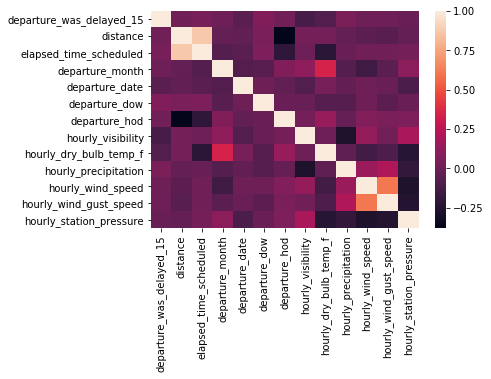

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(features.corr())
plt.show()

In [13]:
import numpy as np

numeric_features = features.select_dtypes(include=[np.number])

In [14]:
numeric_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128 entries, 0 to 1127
Data columns (total 13 columns):
departure_was_delayed_15    1128 non-null int64
distance                    1128 non-null int64
elapsed_time_scheduled      1128 non-null int64
departure_month             1128 non-null int64
departure_date              1128 non-null int64
departure_dow               1128 non-null int64
departure_hod               1128 non-null int64
hourly_visibility           1128 non-null float64
hourly_dry_bulb_temp_f      1128 non-null float64
hourly_precipitation        1128 non-null float64
hourly_wind_speed           1128 non-null float64
hourly_wind_gust_speed      1128 non-null float64
hourly_station_pressure     1128 non-null float64
dtypes: float64(6), int64(7)
memory usage: 123.4 KB


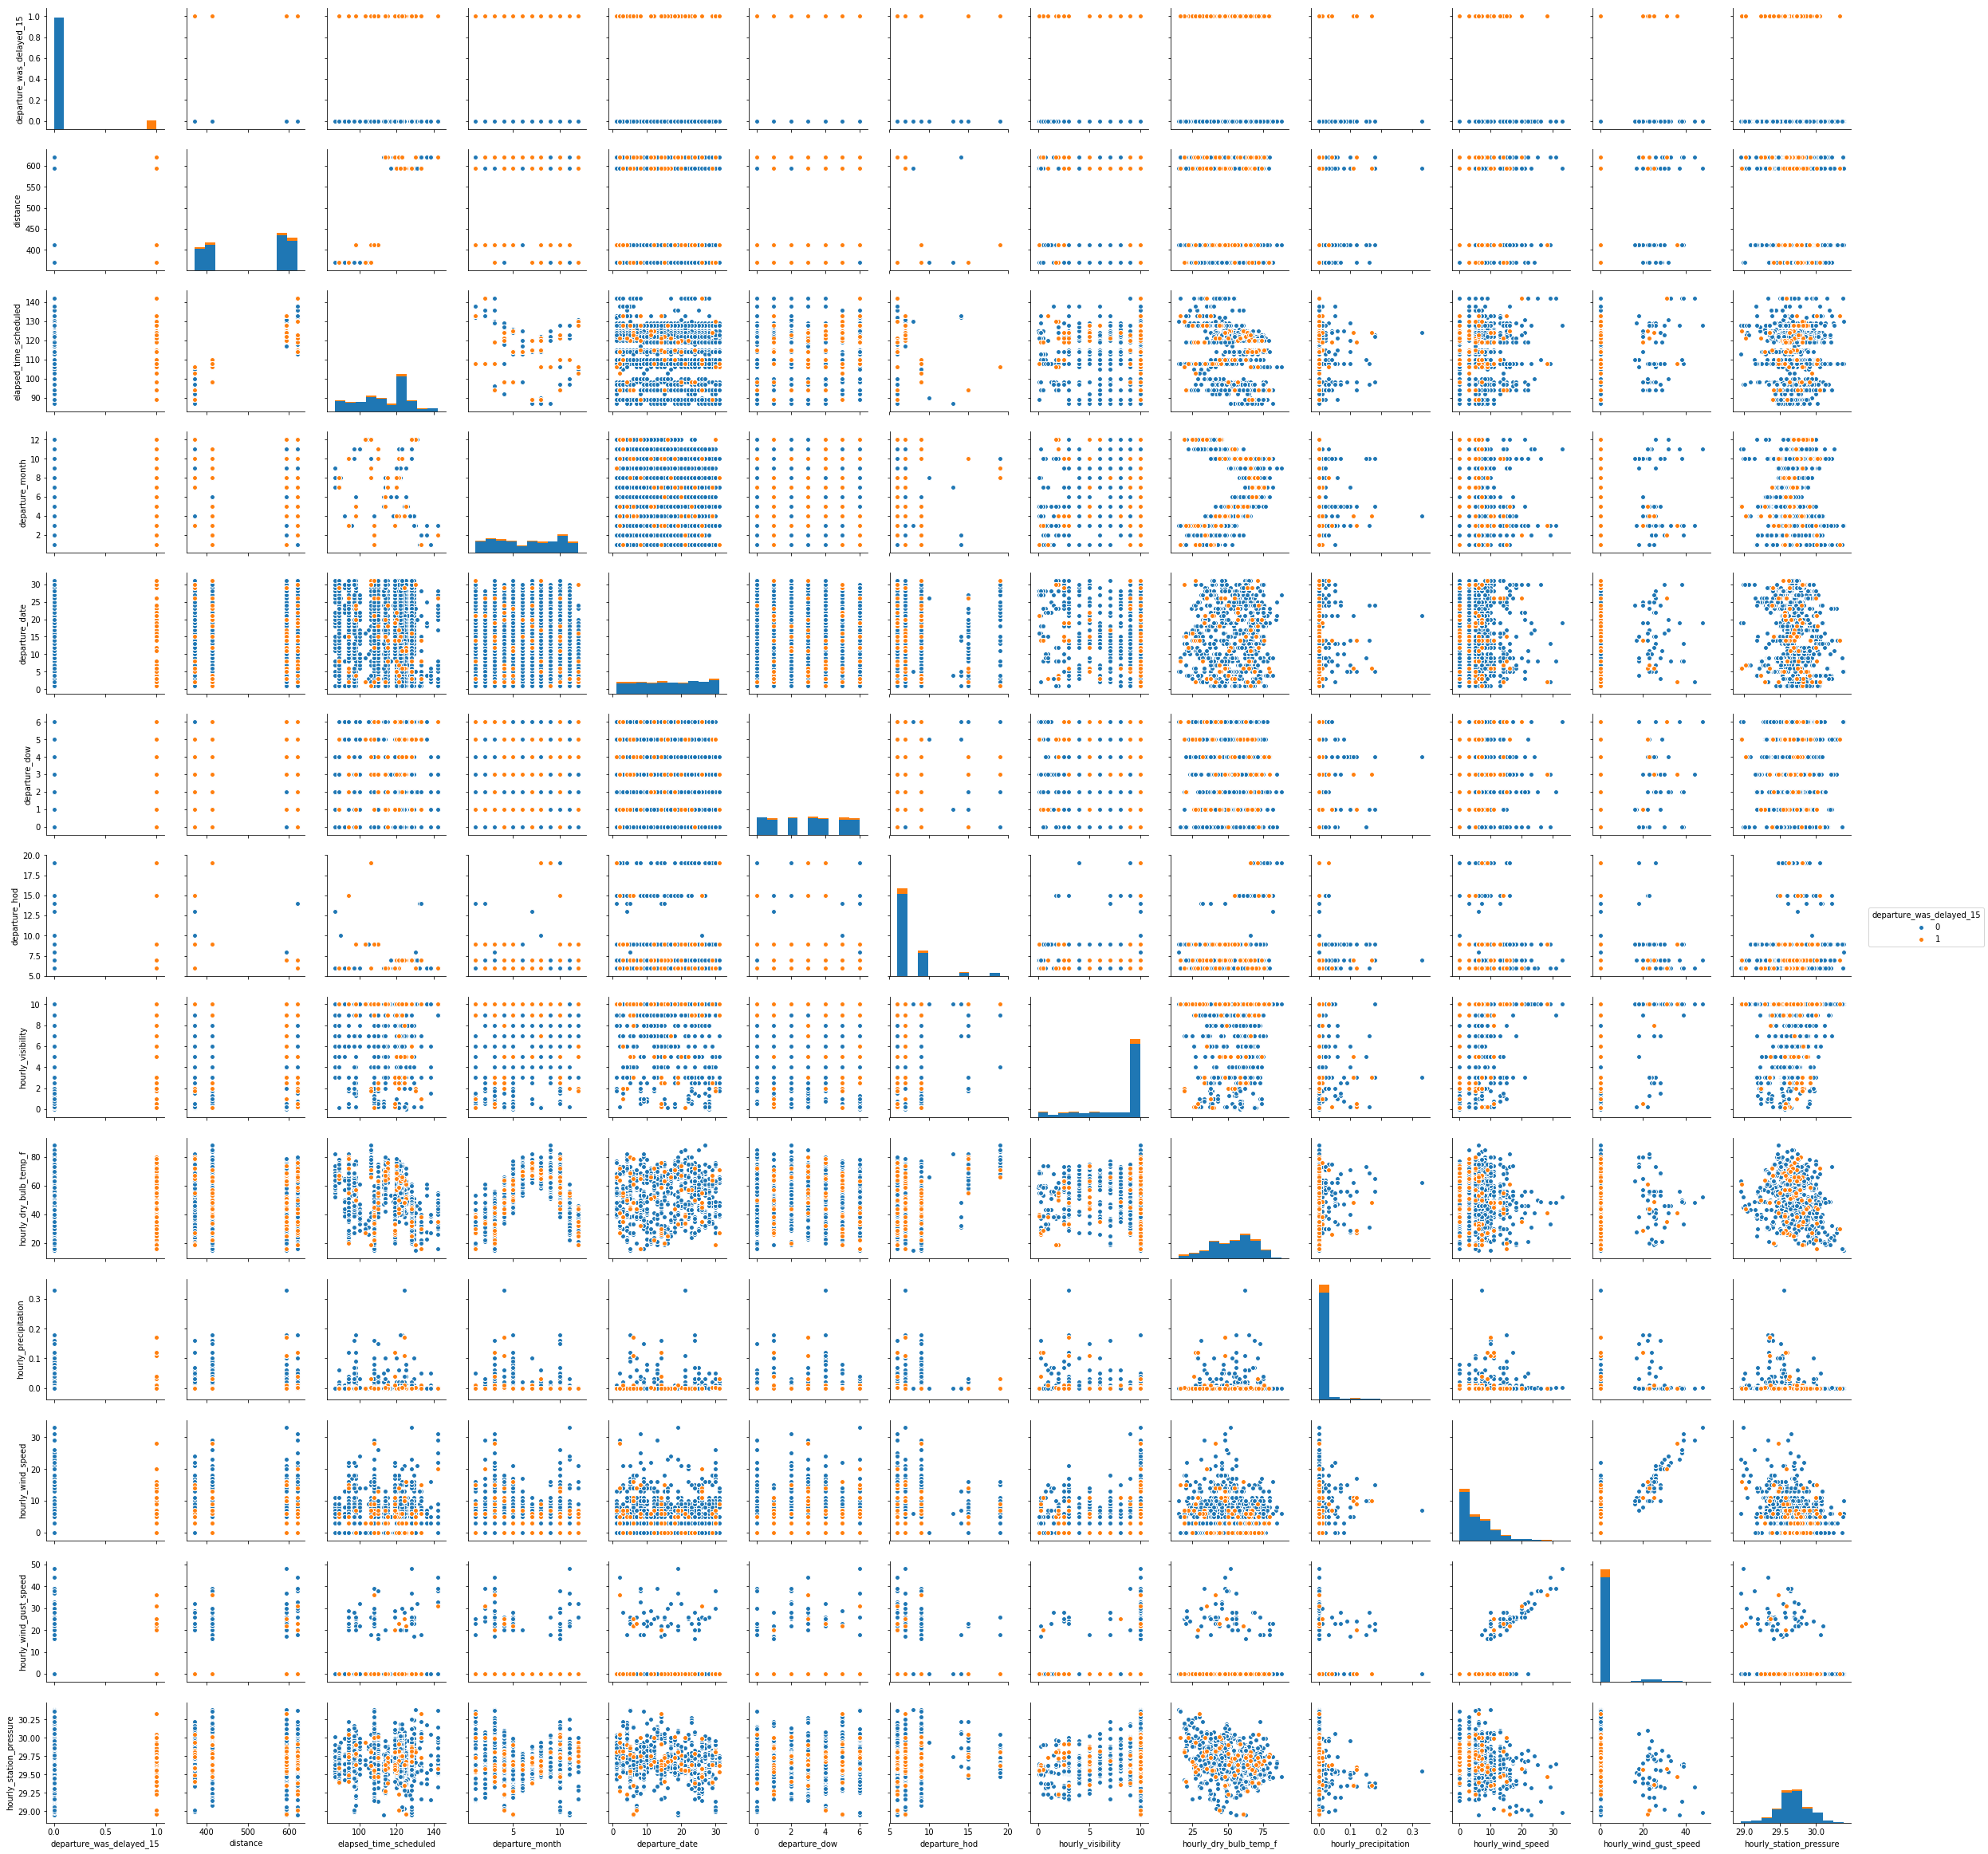

In [19]:
sns.pairplot(data=numeric_features, hue='departure_was_delayed_15')
plt.show()

In [29]:
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd

def estimate_feature_importances(X, y, feature_names):
    forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
    forest.fit(X, y)
    
    features = {}
    for feature, importance in zip(feature_names, forest.feature_importances_):
        features[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(features, orient='index').rename(columns={0: 'Gini-importance'})
    
    importances.sort_values(by='Gini-importance').plot(kind='bar')
    plt.xlabel('Feature')
    plt.ylabel('Gini-Importance')
    plt.title('Feature Importance via RandomForestClassifer')
    plt.show()
    return importances



In [24]:
y = numeric_features['departure_was_delayed_15'].astype(bool)
X = numeric_features.drop('departure_was_delayed_15', axis=1)

feature_names = X.columns

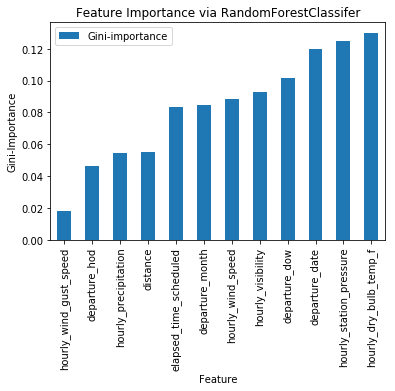

In [30]:
importances = estimate_feature_importances(X=X, y=y, feature_names=feature_names)

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def evalute_classification_model(model, X, y, random_state=42):
    
    """ Encapsulate model fitting and evaulation """
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    # Fit the model
    model.fit(X_train, y_train)
    # Predict on the test data
    y_pred = y_pred = model.predict(X_test)

    # Check the Accuracy
    print("Test Data Mean Accuracy: ", model.score(X_test, y_test))
    # Inspect the results
    print(classification_report(y_pred=y_pred, y_true=y_test))
    
mdl = SVC(kernel='rbf')
evalute_classification_model(mdl, X, y)

Test Data Mean Accuracy:  0.9219858156028369
             precision    recall  f1-score   support

      False       0.92      1.00      0.96       260
       True       0.00      0.00      0.00        22

avg / total       0.85      0.92      0.88       282



/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# Feature Ideas
# Convert to celcius (i.e. center temp around freezinging point + vs negative values handled differently)
# 